# Kaggle - House Prices

This is an exploratory regression problem to predict house prices. 

Several different regression schemes will be tested.

In [143]:
#Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [144]:
#Load Data
df_train = pd.read_csv("train.csv") # importing train dataset
df_test  = pd.read_csv("test.csv")   # importing test dataset

In [145]:
df_train.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

Skewness: 1.882876
Kurtosis: 6.536282


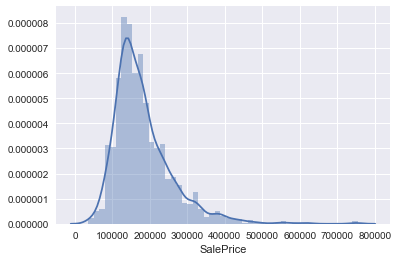

In [146]:
sns.distplot(df_train['SalePrice'])
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

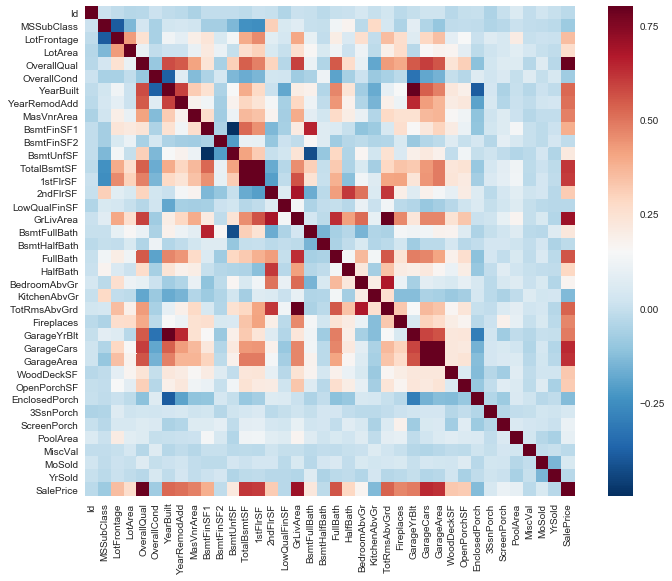

In [147]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu_r");

# This shows us some colinear variables:
# - 1stFlrSF and TotalBsmtSF
# - TotalRMsAbsGrd and GrLivArea
# - GarageYrBlt and YearBuilt
# - GarageCars and GarageArea

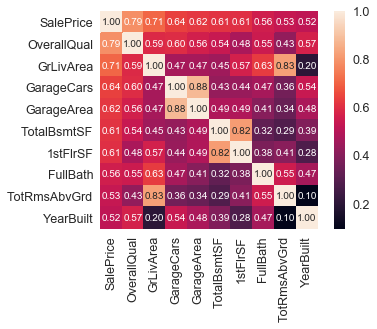

In [148]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# We should probably remove GarageArea since it's collinear with GarageCars
# We should also remove 1stFlSF since it's collinear with TotalBsmtSF
# Save for TotRmsAbsGrd and GrLivArea

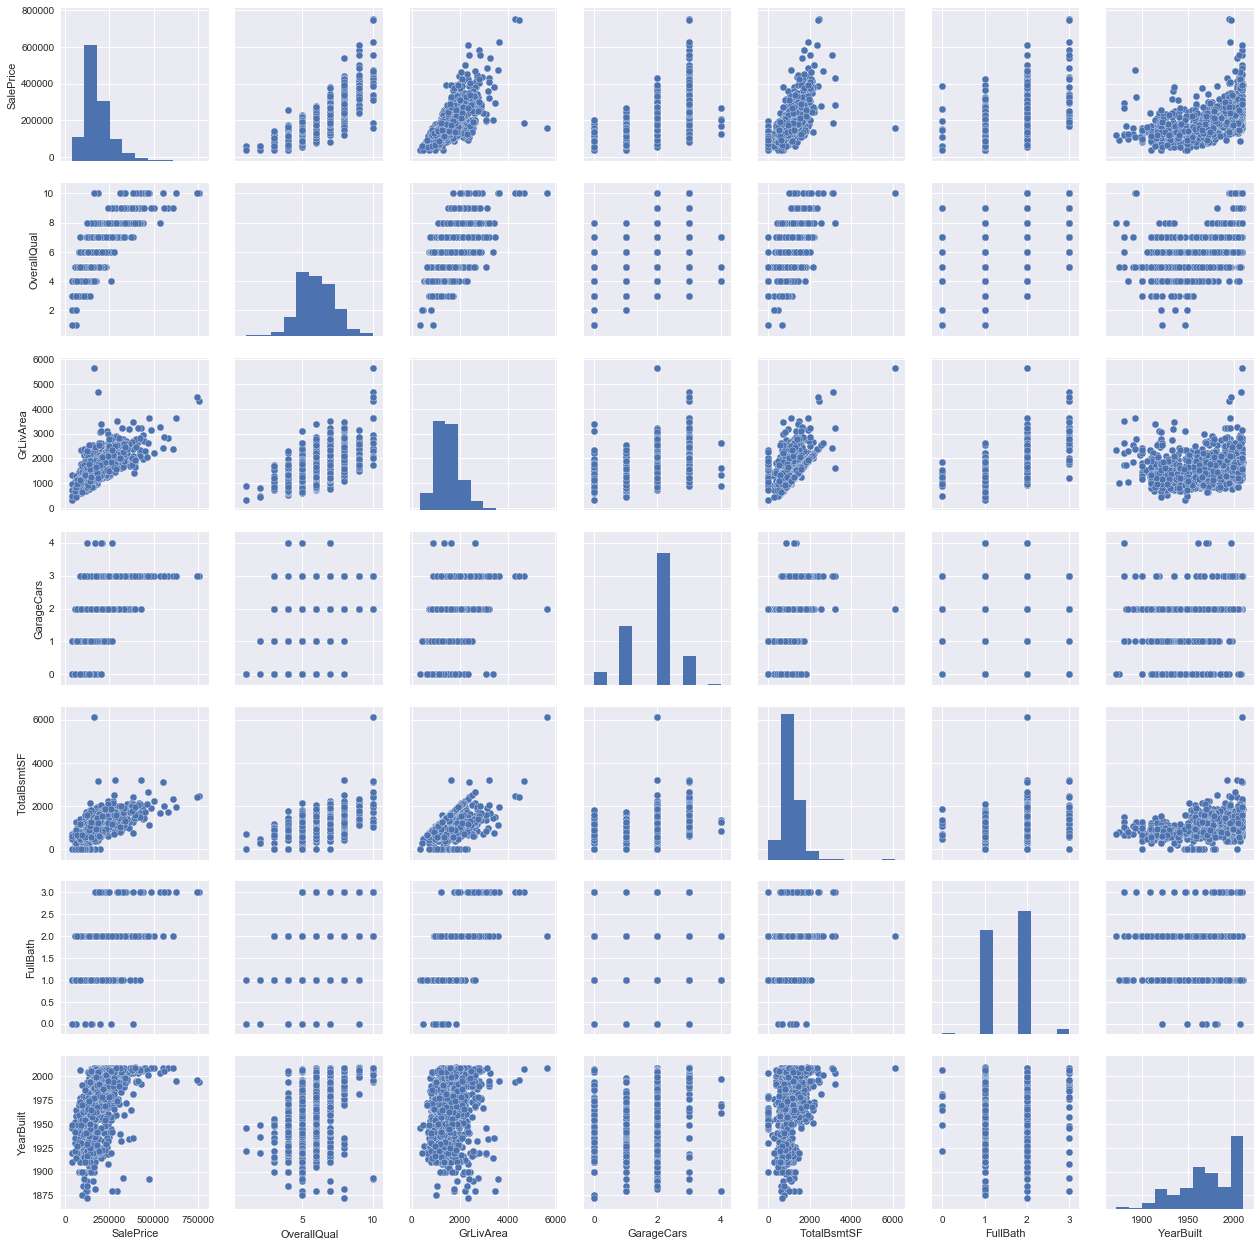

In [149]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

# Now we have a list of 6 features we can play around with

In [150]:
#missing data
total   = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# Obviously PoolQC, MiscFeature, Alley, etc. aren't really helping us out very much
# The GarageX variables tell very similar imformation to the GarageCars variable, which 
# not missing any values. So we can remove these other one's listed here. 
# The BsmtX variables are not strongly correlated with the SalePrice, so we can remove them as well
# The other variables seem unimportant, so we'll delete them as well

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [151]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing..

0

In [152]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


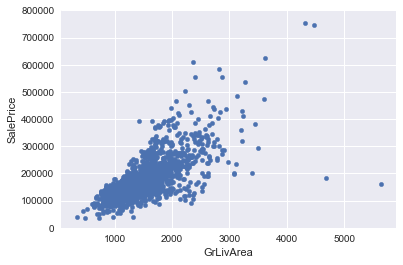

In [153]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

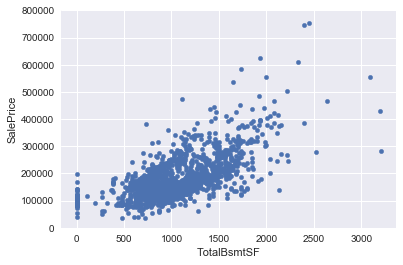

In [154]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Skewness: 1.880363
Kurtosis: 6.516048


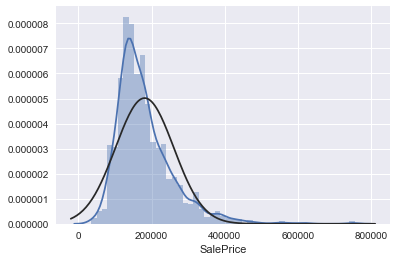

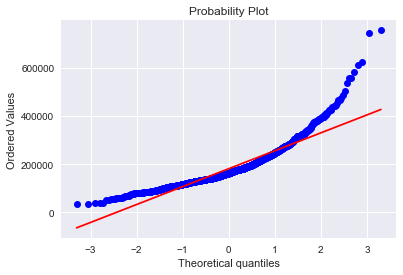

In [155]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

# It's definitely not normally distributed, but we can transform the data such that it is

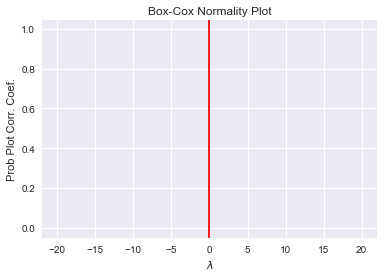

Lambda =  -0.0771515661783


In [156]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.boxcox_normplot(df_train['SalePrice'], -20, 20, plot=ax)
_, maxlog = stats.boxcox(df_train['SalePrice'])
ax.axvline(maxlog, color='r')
plt.show()
print "Lambda = ", maxlog

In [157]:
# Since lambda is close to zero, we can use the log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

Skewness: 0.121551
Kurtosis: 0.802159


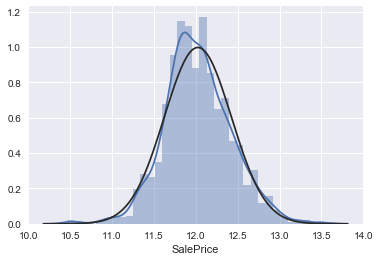

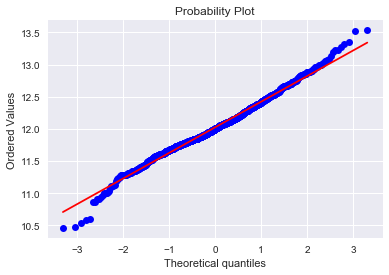

In [158]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.010236
Kurtosis: 2.059720


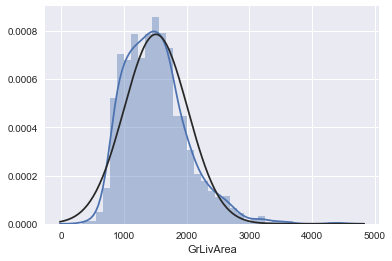

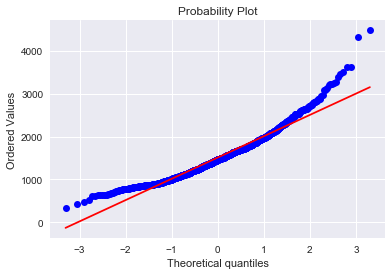

In [159]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

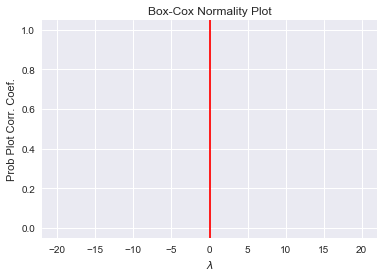

Lambda =  0.0703939501653


In [160]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.boxcox_normplot(df_train['GrLivArea'], -20, 20, plot=ax)
_, maxlog = stats.boxcox(df_train['GrLivArea'])
ax.axvline(maxlog, color='r')
plt.show()
print "Lambda = ", maxlog

In [161]:
# Since lambda is close to zero, we can use the log transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

Skewness: -0.071958
Kurtosis: 0.094248


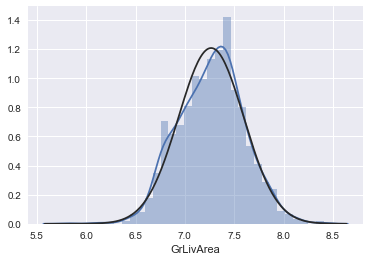

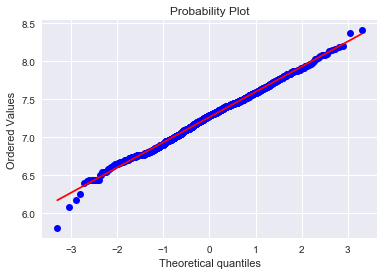

In [162]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 0.512456
Kurtosis: 1.776961


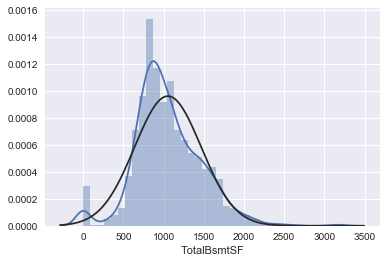

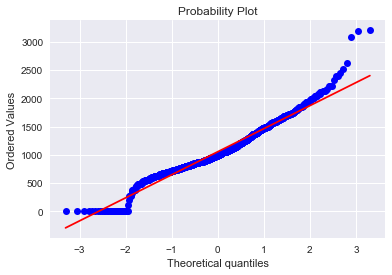

In [163]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

print("Skewness: %f" % df_train['TotalBsmtSF'].skew())
print("Kurtosis: %f" % df_train['TotalBsmtSF'].kurt())

In [164]:
# We'd like to do the same transformation as before, but the zero values are problematic. 
# We'll transform with log(1+p) instead to keep zeros intact
df_train['TotalBsmtSF'] = np.log1p(df_train['TotalBsmtSF'])

Skewness: -5.174316
Kurtosis: 27.838349


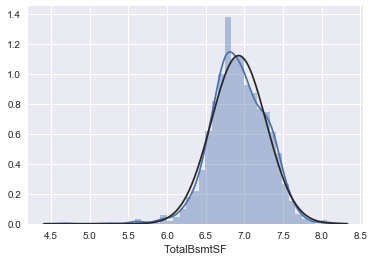

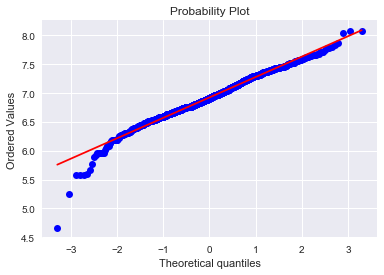

In [168]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

print("Skewness: %f" % df_train['TotalBsmtSF'].skew())
print("Kurtosis: %f" % df_train['TotalBsmtSF'].kurt())

In [166]:
#convert categorical variable into dummy
df_train = pd.get_dummies(df_train)

# Regression Models

In [176]:
# Extract the relevant quantities for regression
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
X_train = df_train[features]
y = df_train.SalePrice

In [177]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))

In [178]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

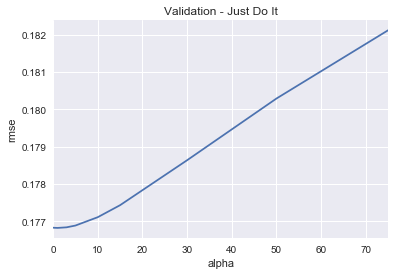

In [179]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [186]:
cv_ridge.min()

0.1768208596424691